# Exploratory Data Analysis

## Library Imports

In [146]:
#General Imports
import pandas as pd
import numpy as np
import time
import random
import math
from collections import namedtuple, Counter
import scipy.stats as stats
from scipy.stats import norm
import datetime

#Scraping Imports
import requests
from bs4 import BeautifulSoup

#Plotting/Graphs
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from wordcloud import WordCloud
%matplotlib inline

#Modelling Imports
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

#Lets you view all columns in a dataframe when there are a LARGE number of columns
pd.set_option('display.max_columns', None)
#Fix for pandas truncating long strings (e.g. urls)
#If you don't run this, pandas will cut short your long urls and this breaks code that require urls
pd.set_option("display.max_colwidth", 10000)

## Table of Contents <a id='Table of Contents'></a> 

- <a href='#Activity'>1. Gauging Subreddit Activity</a>
    - <a href='#PostsDay'>1.1 Number of Posts/Day</a>
    - <a href='#CommentsDay'>1.2 Number of Comments/Day</a>
    - <a href='#PostTypes'>1.3 Post Types</a>
- <a href='#WordCount'>2. Word Counts</a>
- <a href='#Sentiment'>3. Sentiment Analysis</a>
    - <a href='#SentimentOverTime'>3.1 Sentiment Over Time</a>
    - <a href='#SentimentDistribution'>3.2 Sentiment Distribution</a>
    - <a href='#PostTypes'>1.3 Post Types</a>
- <a href='#WordClouds'>4. Word Clouds</a>

## Reading in Data

In [219]:
df_combined = pd.read_csv(r".\datasets\reddit_cleaned.csv")

In [220]:
#Fill NA, just in case - this would have been done in the cleaning step, 
#but I will run it again here so no weird errors are thrown later on.
df_combined = df_combined.fillna('')

In [221]:
df_combined.columns

Index(['Unnamed: 0', 'subreddit_name_prefixed', 'author', 'title', 'selftext',
       'domain', 'link_flair_text', 'created', 'media', 'media_embed', 'url',
       'permalink', 'num_comments', 'score', 'ups', 'comments', 'ocr',
       'tweet_text', 'combined', 'title_word_count', 'selftext_word_count',
       'comments_word_count', 'combined_word_count', 'title_sentiment_neg',
       'title_sentiment_neu', 'title_sentiment_pos', 'selftext_sentiment_neg',
       'selftext_sentiment_neu', 'selftext_sentiment_pos',
       'comments_sentiment_neg', 'comments_sentiment_neu',
       'comments_sentiment_pos', 'combined_sentiment_neg',
       'combined_sentiment_neu', 'combined_sentiment_pos'],
      dtype='object')

In [222]:
df_combined.dtypes

Unnamed: 0                   int64
subreddit_name_prefixed      int64
author                      object
title                       object
selftext                    object
domain                      object
link_flair_text             object
created                     object
media                       object
media_embed                 object
url                         object
permalink                   object
num_comments                 int64
score                        int64
ups                          int64
comments                    object
ocr                         object
tweet_text                  object
combined                    object
title_word_count             int64
selftext_word_count          int64
comments_word_count          int64
combined_word_count          int64
title_sentiment_neg        float64
title_sentiment_neu        float64
title_sentiment_pos        float64
selftext_sentiment_neg     float64
selftext_sentiment_neu     float64
selftext_sentiment_p

## 1. Gauging Subreddit Activity <a id='Activity'></a> 
<div align="right"><a href='#Table of Contents'>Back to Table of Contents</a></div>

### 1.1 Number of Posts Per Day <a id='PostsDay'></a> 
<div align="right"><a href='#Table of Contents'>Back to Table of Contents</a></div>

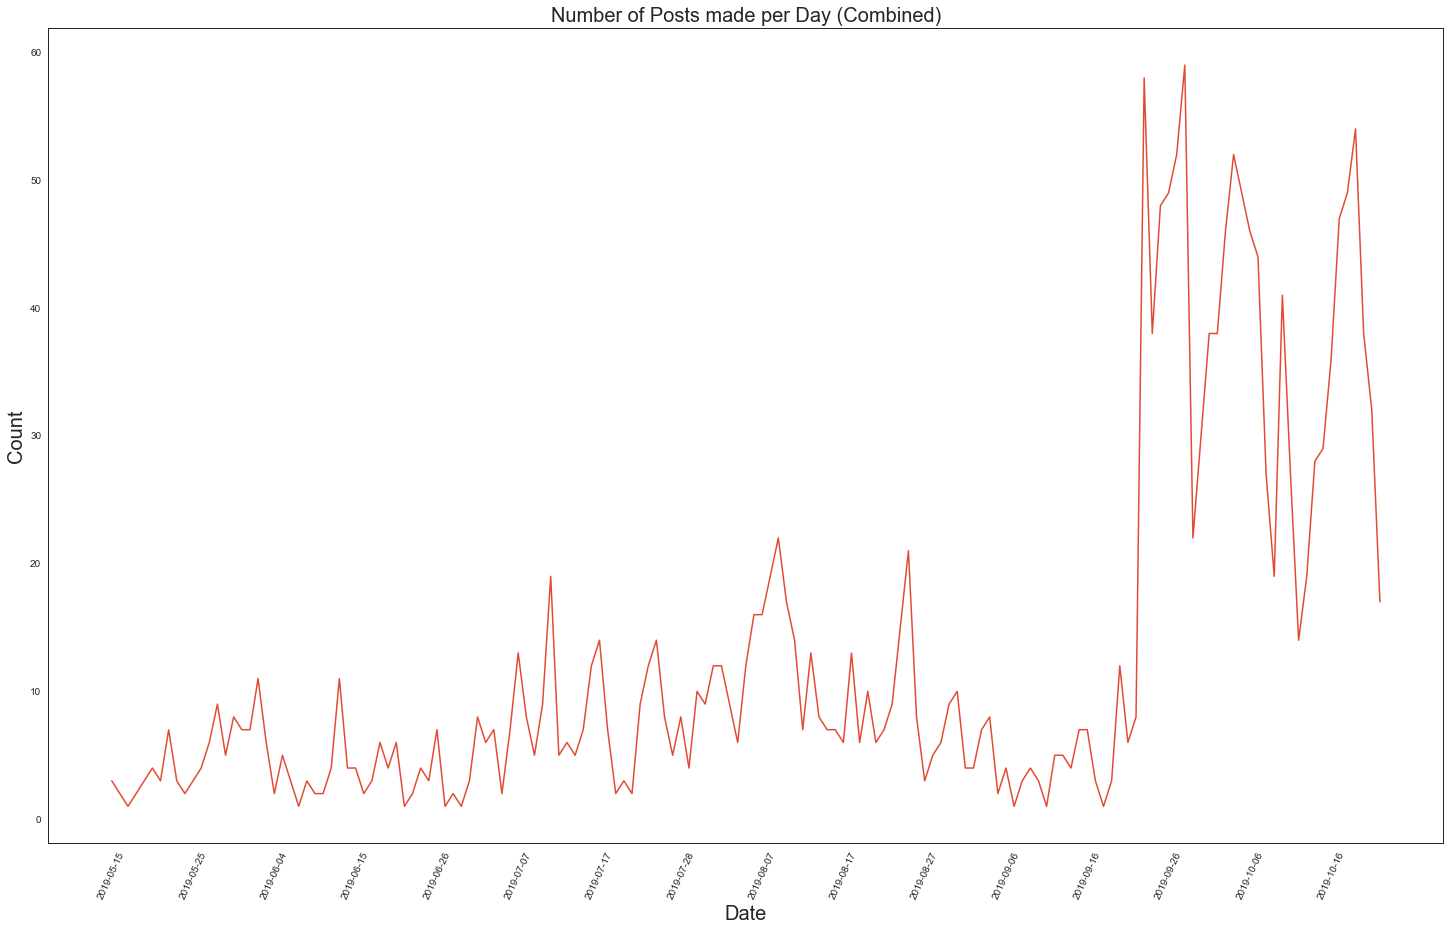

In [231]:
sns.set_style('white')
ax = plt.figure(figsize = (25, 15))
ax = sns.lineplot(data = df_combined.groupby('created')['title'].agg('count'))
plt.setp(ax.get_xticklabels(), rotation=65)
ax.set_title("Number of Posts made per Day (Combined)", fontsize = 20)
ax.set_xlabel("Date", fontsize = 20)
ax.set_ylabel("Count", fontsize = 20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

<b>Analysis</b>

There is a sharp spike in the number of total posts after September. To investigate why this is the case, we will break down the combined posts into posts for FPL and posts for EPL.

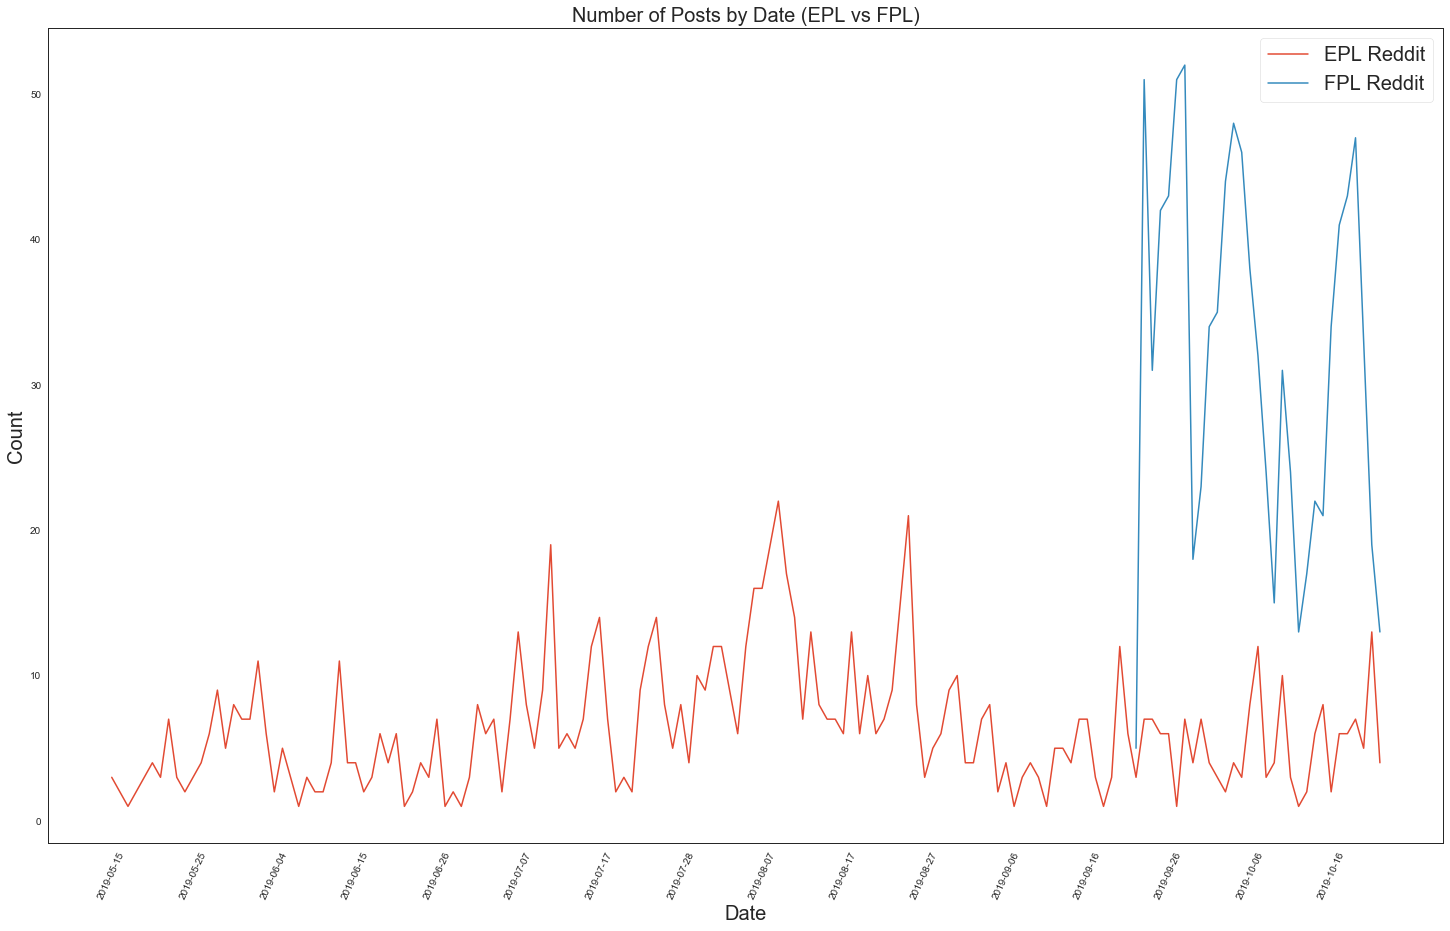

In [235]:
sns.set_style('white')
ax = plt.figure(figsize = (25, 15))
ax = sns.lineplot(data = df_combined[df_combined['subreddit_name_prefixed']==1].groupby('created')['title'].agg('count'), label="EPL Reddit")
sns.lineplot(data = df_combined[df_combined['subreddit_name_prefixed']==0].groupby('created')['title'].agg('count'), label="FPL Reddit")

plt.setp(ax.get_xticklabels(), rotation=65)
ax.set_title("Number of Posts by Date (EPL vs FPL)", fontsize = 20)
ax.set_xlabel("Date", fontsize = 20)
ax.set_ylabel("Count", fontsize = 20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.legend(fontsize = 20)

<b>Analysis of Dates</b>

Due to the differing popularity of the two subreddits (r/FPL is far more popular than r/EPL, surprisingly), a crawl of the last 1000 posts yields differing dates. My interpretations are as follows:
<li>r/FPL took 2 months to gather 1000 posts, but r/EPL took 5 months to gather 1000 posts.</li>
<li>r/FPL is a far more active subreddit - it peaks at 52 posts in a day. r/EPL, on the other hand, peaks at 22 posts in a day.
<li>The spikes in posts coincide with weekends - i.e. when the EPL games are played.</li>
<li>These differences could affect the final output and analysis, because having data across different time periods introduces extraneous variables that could confound results. </li>

### 1.2 Number of Comments per Day <a id='CommentsDay'></a> 
<div align="right"><a href='#Table of Contents'>Back to Table of Contents</a></div>

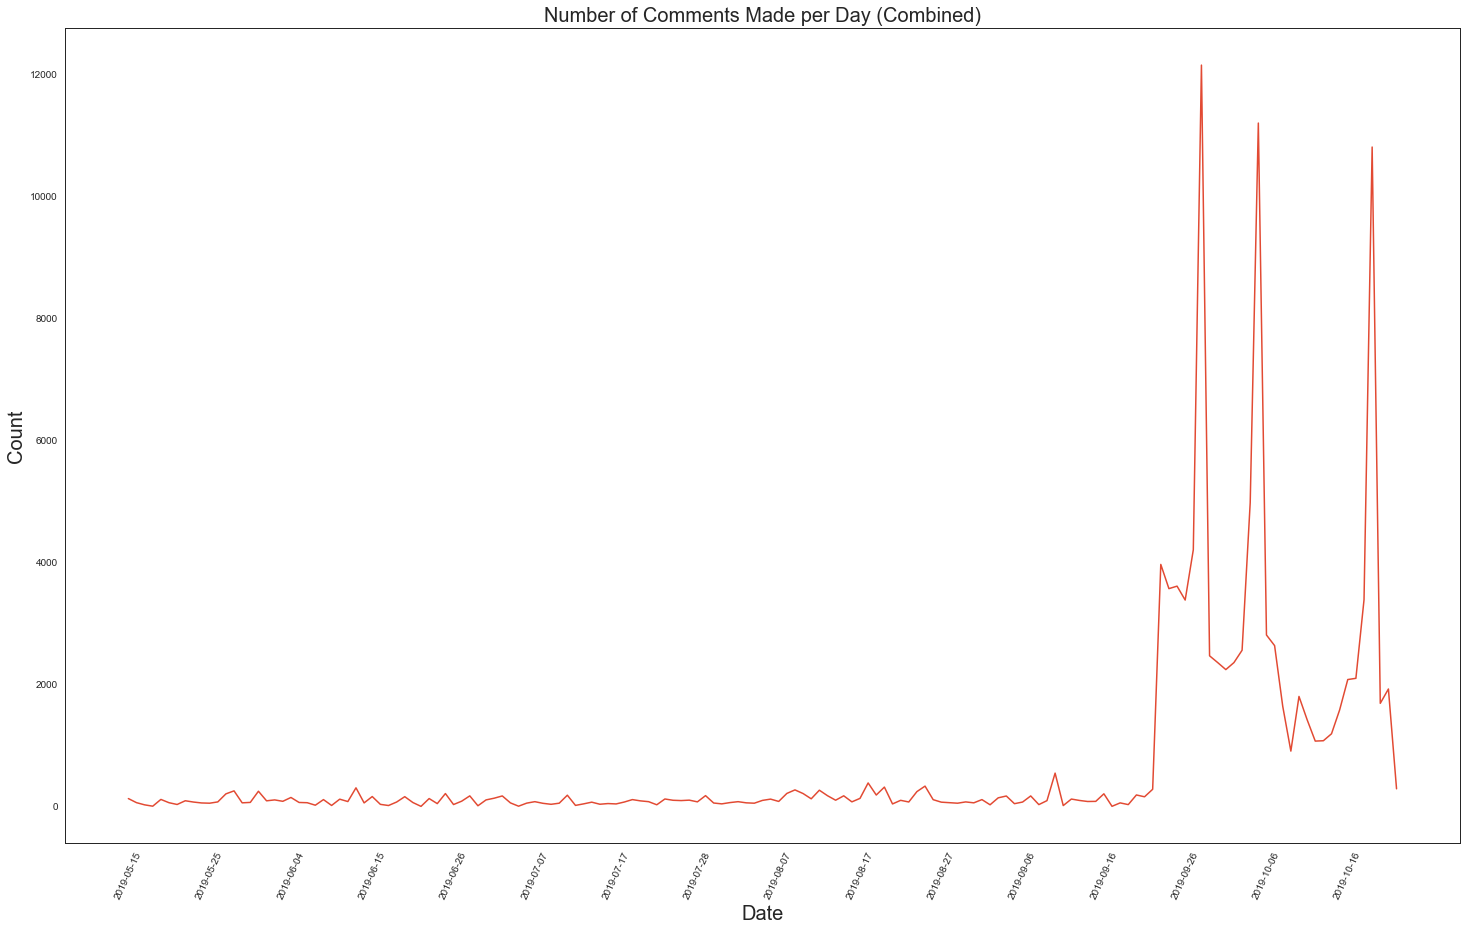

In [236]:
sns.set_style('white')
ax = plt.figure(figsize = (25, 15))
ax = sns.lineplot(data = df_combined.groupby('created')['num_comments'].agg('sum'))
plt.setp(ax.get_xticklabels(), rotation=65)
ax.set_title("Number of Comments Made per Day (Combined)", fontsize = 20)
ax.set_xlabel("Date", fontsize = 20)
ax.set_ylabel("Count", fontsize = 20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

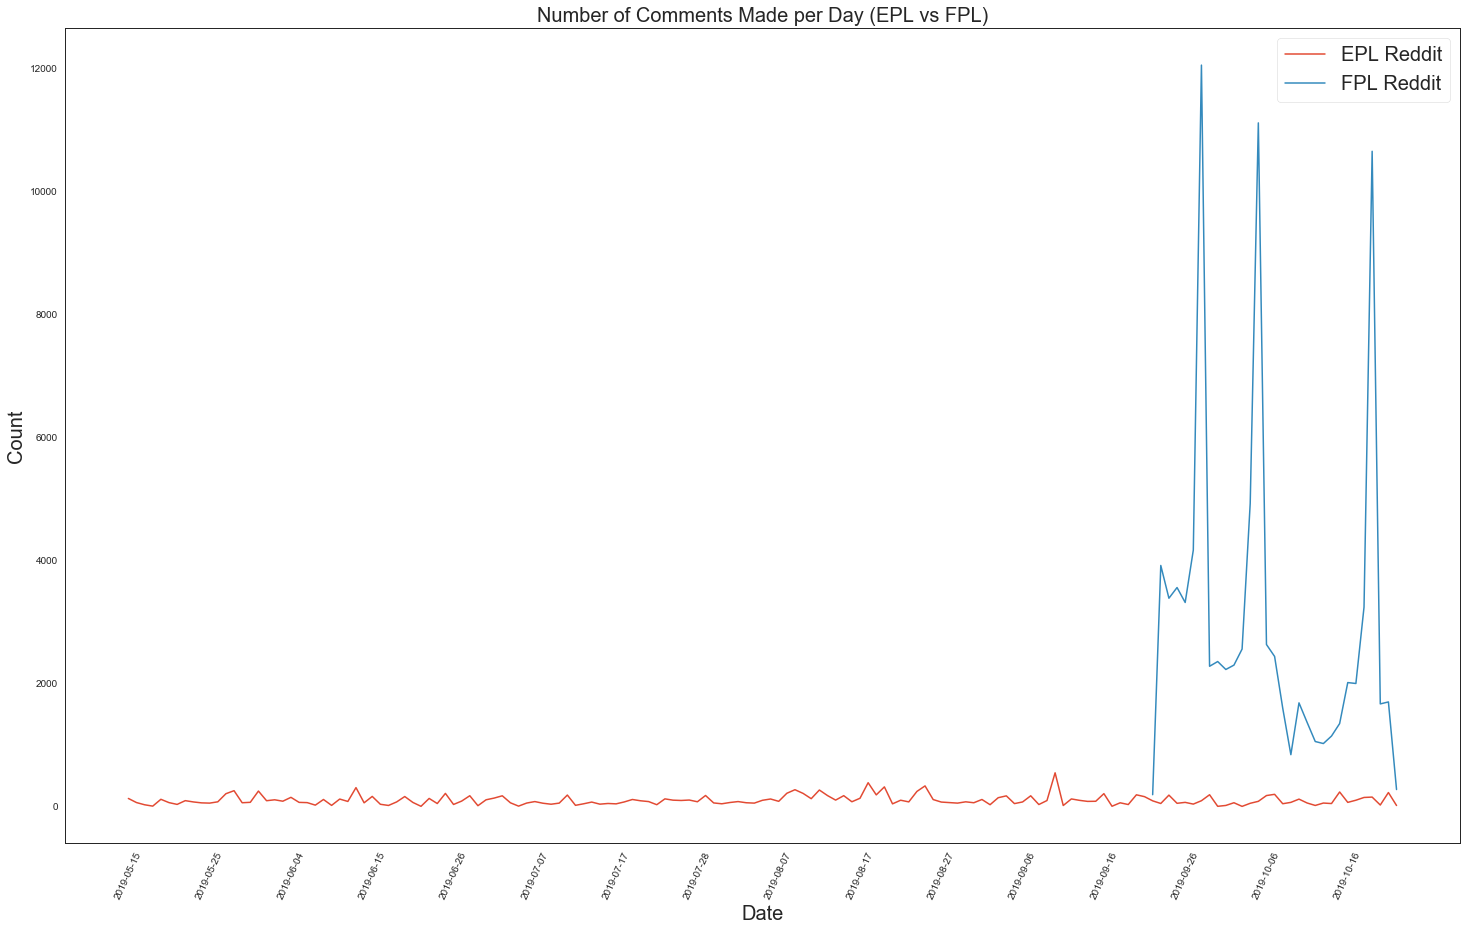

In [238]:
sns.set_style('white')
ax = plt.figure(figsize = (25, 15))
ax = sns.lineplot(data = df_combined[df_combined['subreddit_name_prefixed']==1].groupby('created')['num_comments'].agg('sum'), label="EPL Reddit")
sns.lineplot(data = df_combined[df_combined['subreddit_name_prefixed']==0].groupby('created')['num_comments'].agg('sum'), label="FPL Reddit")

plt.setp(ax.get_xticklabels(), rotation=65)
ax.set_title("Number of Comments Made per Day (EPL vs FPL)", fontsize = 20)
ax.set_xlabel("Date", fontsize = 20)
ax.set_ylabel("Count", fontsize = 20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.legend(fontsize = 20)

<b>Analysis of Comments</b>

Once again, due to the differing popularity of the two subreddits, r/FPL has much higher activity, with its users being much more engaged in posts and commenting actively.

Some interpretations:
<li>The spikes in comments coincide with weekends - i.e. when the EPL games are played.</li>
<li>Care needs to be taken when interpreting models that use the comments dataset, since the data here is so skewed towards r/FPL.</li>

### 1.3 Post Type <a id='PostType'></a> 
<div align="right"><a href='#Table of Contents'>Back to Table of Contents</a></div>

In [259]:
post_type = df_combined.groupby('domain').agg('count')[df_combined.groupby('domain').agg('count')['title'] > 20]

Text(0.5, 1.0, 'Count of Domain Type')

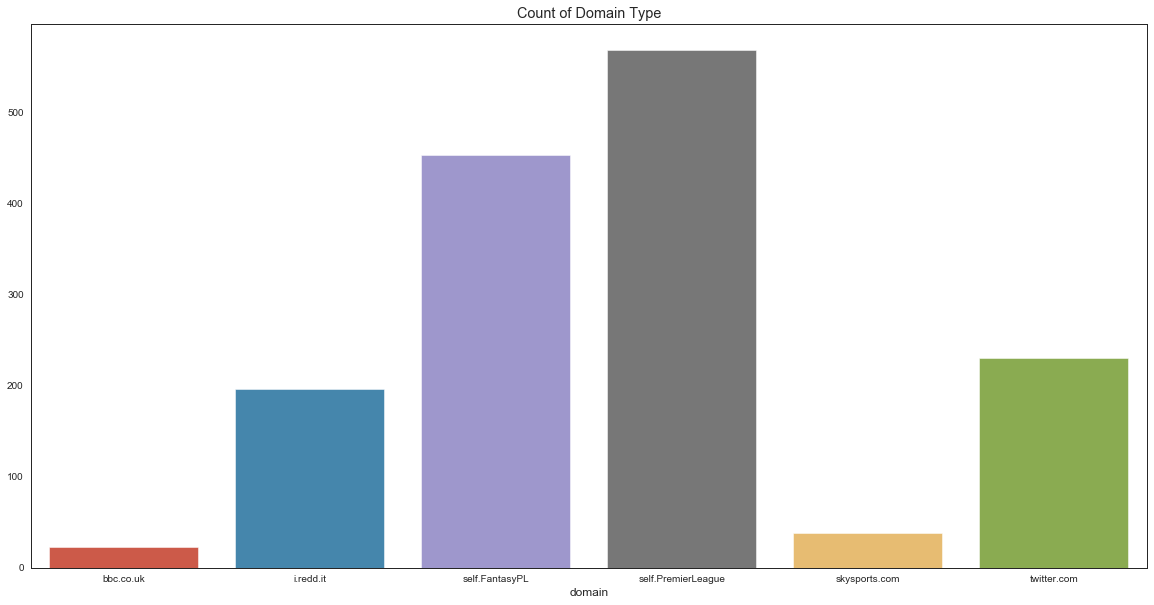

In [273]:
ax = plt.figure(figsize = (20, 10))
sns.barplot(x = post_type.index, y = post_type['title'].values)
plt.title("Count of Domain Type")

Above are the domain of posts for any domain with more than 20 posts (i.e. link posts to obscure sites that appear less than 20 times in 1000 posts are not included here).

To understand this bar graph we have to distinguish between self posts and link posts: self posts are basically text posts where a redditor types in the content. Link posts are basically links to outside of reddit.

The finding here is that r/EPL has far more self posts than r/FPL. Both subreddits are also very found of posting tweets.

## 2. Word Count <a id='WordCount'></a> 
<div align="right"><a href='#Table of Contents'>Back to Table of Contents</a></div>

In [120]:
plt.style.use('ggplot')
def subplot_histograms(dataframe, list_of_columns, cols = 3, binz = 10):
    nrows = int(np.ceil(len(list_of_columns)/cols)) # Makes sure you have enough rows
    
    #Scales the height of the fig to accomodate a long list of features    
    fig, ax = plt.subplots(nrows=nrows, ncols=cols, figsize=(25, len(list_of_columns)*(10/cols))) 
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
        sns.distplot(dataframe[column], ax=ax[i], bins = binz, fit=norm, kde=True) 
        mean_val = dataframe[column].mean()
        
        #runs D’Agostino's normality test to print on graph
        normality_test = stats.normaltest(dataframe[column]).pvalue < 0.05
        ax[i].set_title("Histogram for {}".format(list_of_columns[i]))
        ax[i].set_xlabel(list_of_columns[i]) 
        ax[i].axvline(x = mean_val, label = "mean", color = "darkred").set_linestyle("--")
        ax[i].text(0.75, 0.83, "Normal: {}".format(not normality_test), ha="left", va="top", transform=ax[i].transAxes, fontsize=12)
        ax[i].legend()

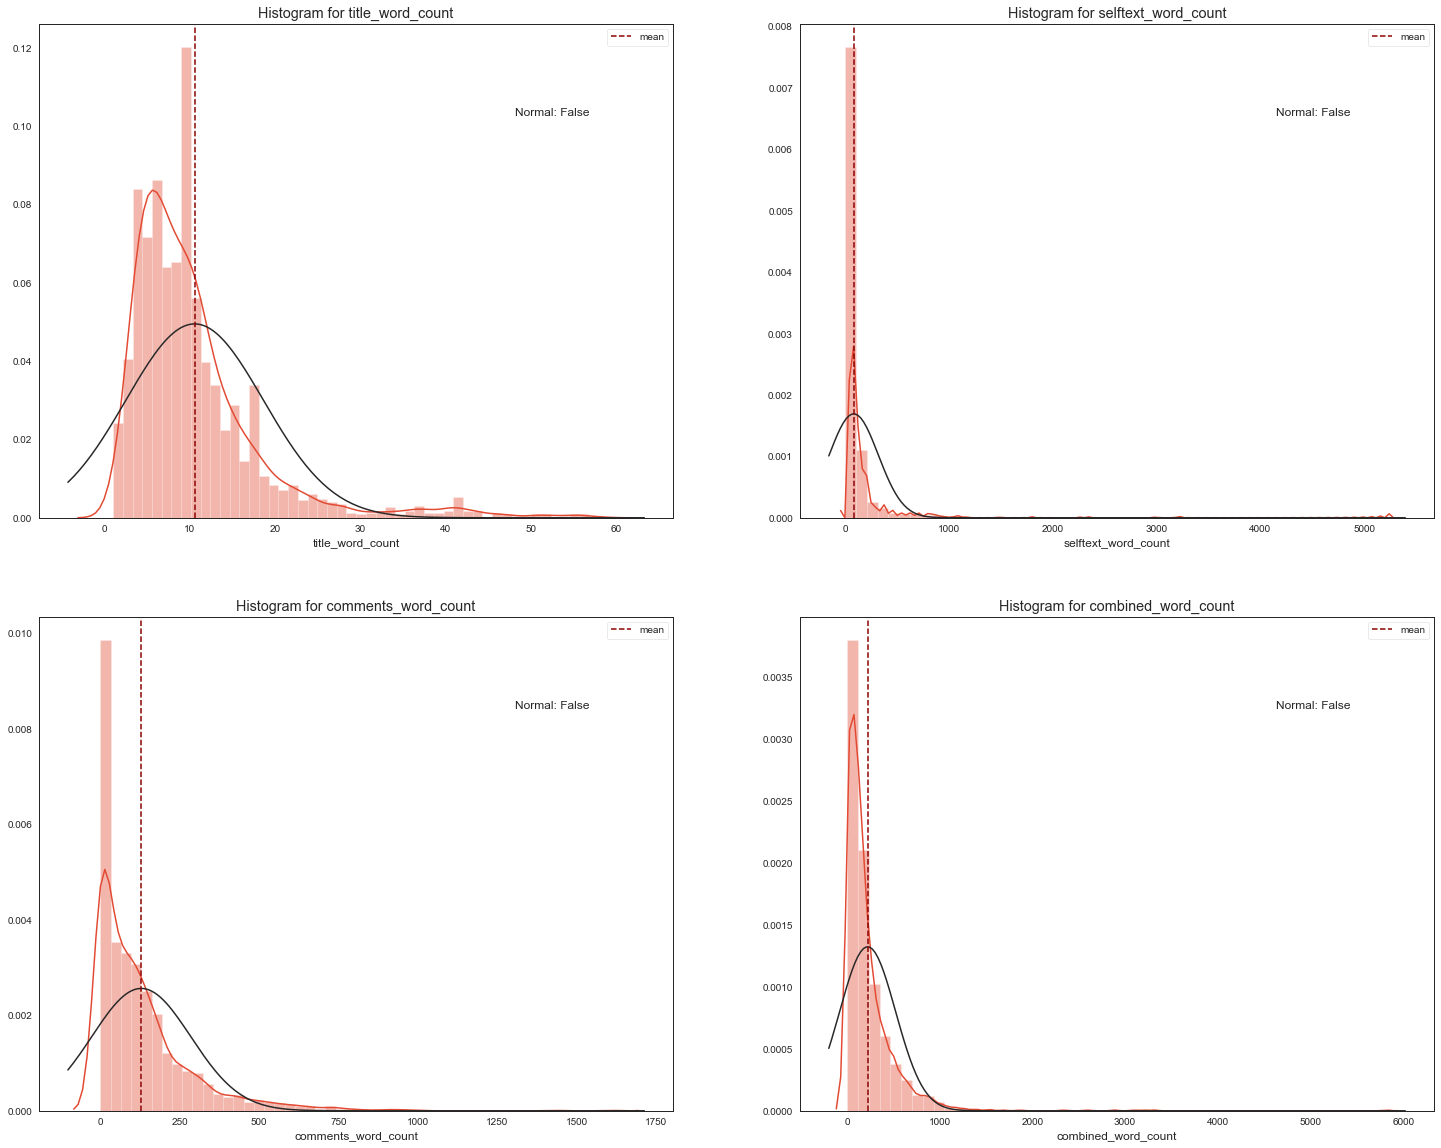

In [132]:
subplot_histograms(df_combined, ['title_word_count', 'selftext_word_count', 'comments_word_count', 'combined_word_count'], cols = 2, binz = 50)

In [142]:
pd.DataFrame([[df_combined[df_combined['subreddit_name_prefixed']==0]['title_word_count'].mean(),
              df_combined[df_combined['subreddit_name_prefixed']==0]['selftext_word_count'].mean(),
              df_combined[df_combined['subreddit_name_prefixed']==0]['comments_word_count'].mean(),
              df_combined[df_combined['subreddit_name_prefixed']==0]['combined_word_count'].mean()],
             [df_combined[df_combined['subreddit_name_prefixed']==1]['title_word_count'].mean(),
              df_combined[df_combined['subreddit_name_prefixed']==1]['selftext_word_count'].mean(),
              df_combined[df_combined['subreddit_name_prefixed']==1]['comments_word_count'].mean(),
              df_combined[df_combined['subreddit_name_prefixed']==1]['combined_word_count'].mean()]],
             index = ['FPL', 'EPL'], columns = ['title', 'selftext', 'comments', 'combined'])


title    selftext    comments    combined
FPL  10.418182  106.323232  150.102020  265.161616
EPL  10.710130   64.304915  107.094283  180.844534

The table above captures the mean word count for each data set.

In general, FPL selftext and comments are more verbose than EPL, while titles are generally similar in length.

The word counts for self text and comments are also very left skewed - there are outliers (people who write very long self text posts or comments). 

## 3. Sentiment Analysis <a id='Sentiment'></a> 
<div align="right"><a href='#Table of Contents'>Back to Table of Contents</a></div>

Negative, postive, and neutral sentiments were calculated per post using VaderSentiment.

### 3.1 Sentiment Over Time  <a id='SentimentOverTime'></a> 
<div align="right"><a href='#Table of Contents'>Back to Table of Contents</a></div>

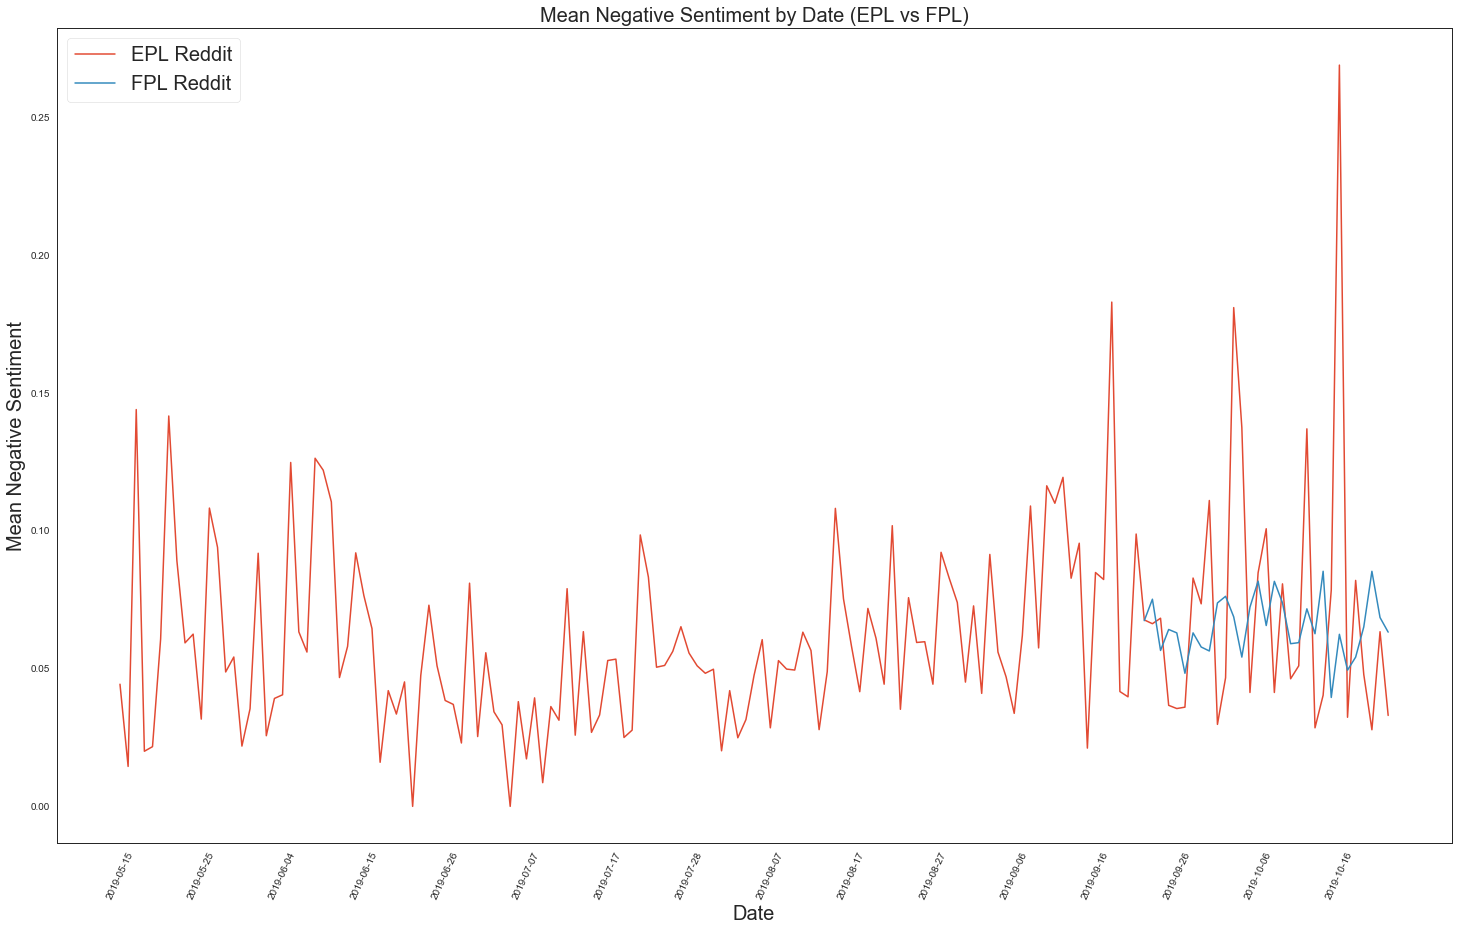

In [229]:
sns.set_style('white')
ax = plt.figure(figsize = (25, 15))
ax = sns.lineplot(data = df_combined[df_combined['subreddit_name_prefixed']==1].groupby('created')['combined_sentiment_neg'].agg('mean'), label="EPL Reddit")
sns.lineplot(data = df_combined[df_combined['subreddit_name_prefixed']==0].groupby('created')['combined_sentiment_neg'].agg('mean'), label="FPL Reddit")

plt.setp(ax.get_xticklabels(), rotation=65)
ax.set_title("Mean Negative Sentiment by Date (EPL vs FPL)", fontsize = 20)
ax.set_xlabel("Date", fontsize = 20)
ax.set_ylabel("Mean Negative Sentiment", fontsize = 20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.legend(fontsize = 20)

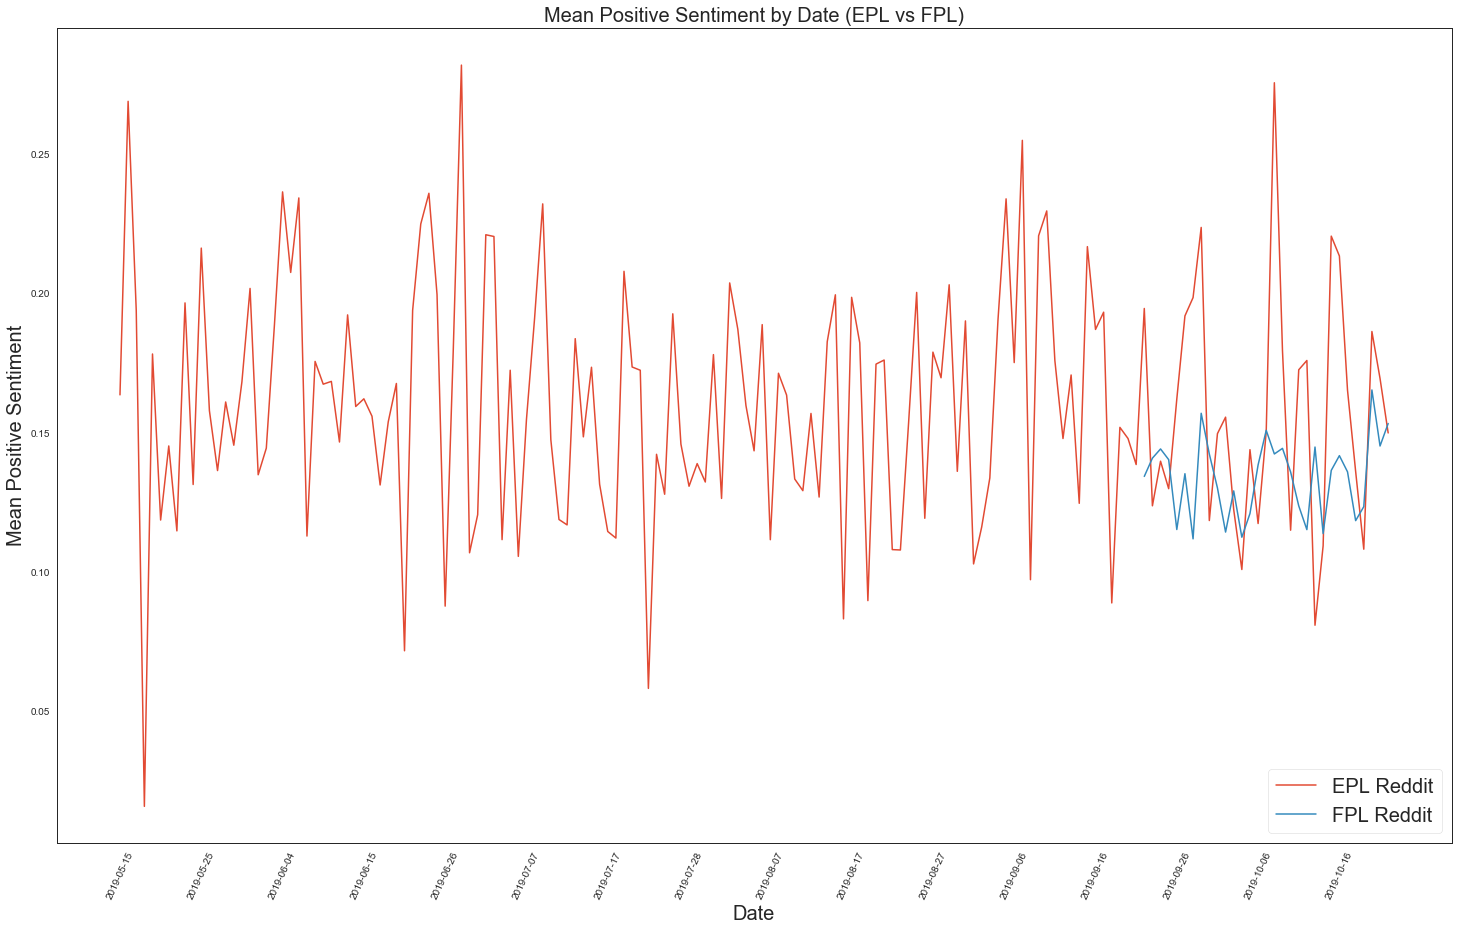

In [230]:
sns.set_style('white')
ax = plt.figure(figsize = (25, 15))
ax = sns.lineplot(data = df_combined[df_combined['subreddit_name_prefixed']==1].groupby('created')['combined_sentiment_pos'].agg('mean'), label="EPL Reddit")
sns.lineplot(data = df_combined[df_combined['subreddit_name_prefixed']==0].groupby('created')['combined_sentiment_pos'].agg('mean'), label="FPL Reddit")

plt.setp(ax.get_xticklabels(), rotation=65)
ax.set_title("Mean Positive Sentiment by Date (EPL vs FPL)", fontsize = 20)
ax.set_xlabel("Date", fontsize = 20)
ax.set_ylabel("Mean Positive Sentiment", fontsize = 20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.legend(fontsize = 20)

<b> Analysis </b>

r/EPL redditors appear to have greater spikes in positive and negative sentiment, while FPL players are less prone to swings. There could be multiple explanations for this:

<li> Fewer EPL posts; therefore the mean sentiment could swing wildly due to outliers. </li>
<li> Perhaps FPL players are more calm - it is a numbers game after all, where you set aside what team you support in order to maximize point gains. For example, I support Manchester United, but I have very few Man U players because they have been absolutely terrible this season. I set aside my feelings and pain in order to do well in FPL. </li>


### 3.2 Sentiment Distribution  <a id='SentimentDistribution'></a> 
<div align="right"><a href='#Table of Contents'>Back to Table of Contents</a></div>

Below, we have histograms for each sentiment (pos, neu, neg) across each data set (title only, selftext only, comments only, combined). This is also broken down into three sections - combined (both EPL and FPL subreddits), EPL subreddit only, and FPL subreddit only.

### 3.2.1 Combined (EPL + FPL subreddits)

In [129]:
list_of_columns = [i for i in df_combined.columns if df_combined[i].dtype=="float64"]

Each row for the graphs below capture the data set (i.e. title only, selftext only, comments only, all three combined).

Each column captures the type of sentiment (negative, neutral, positive)

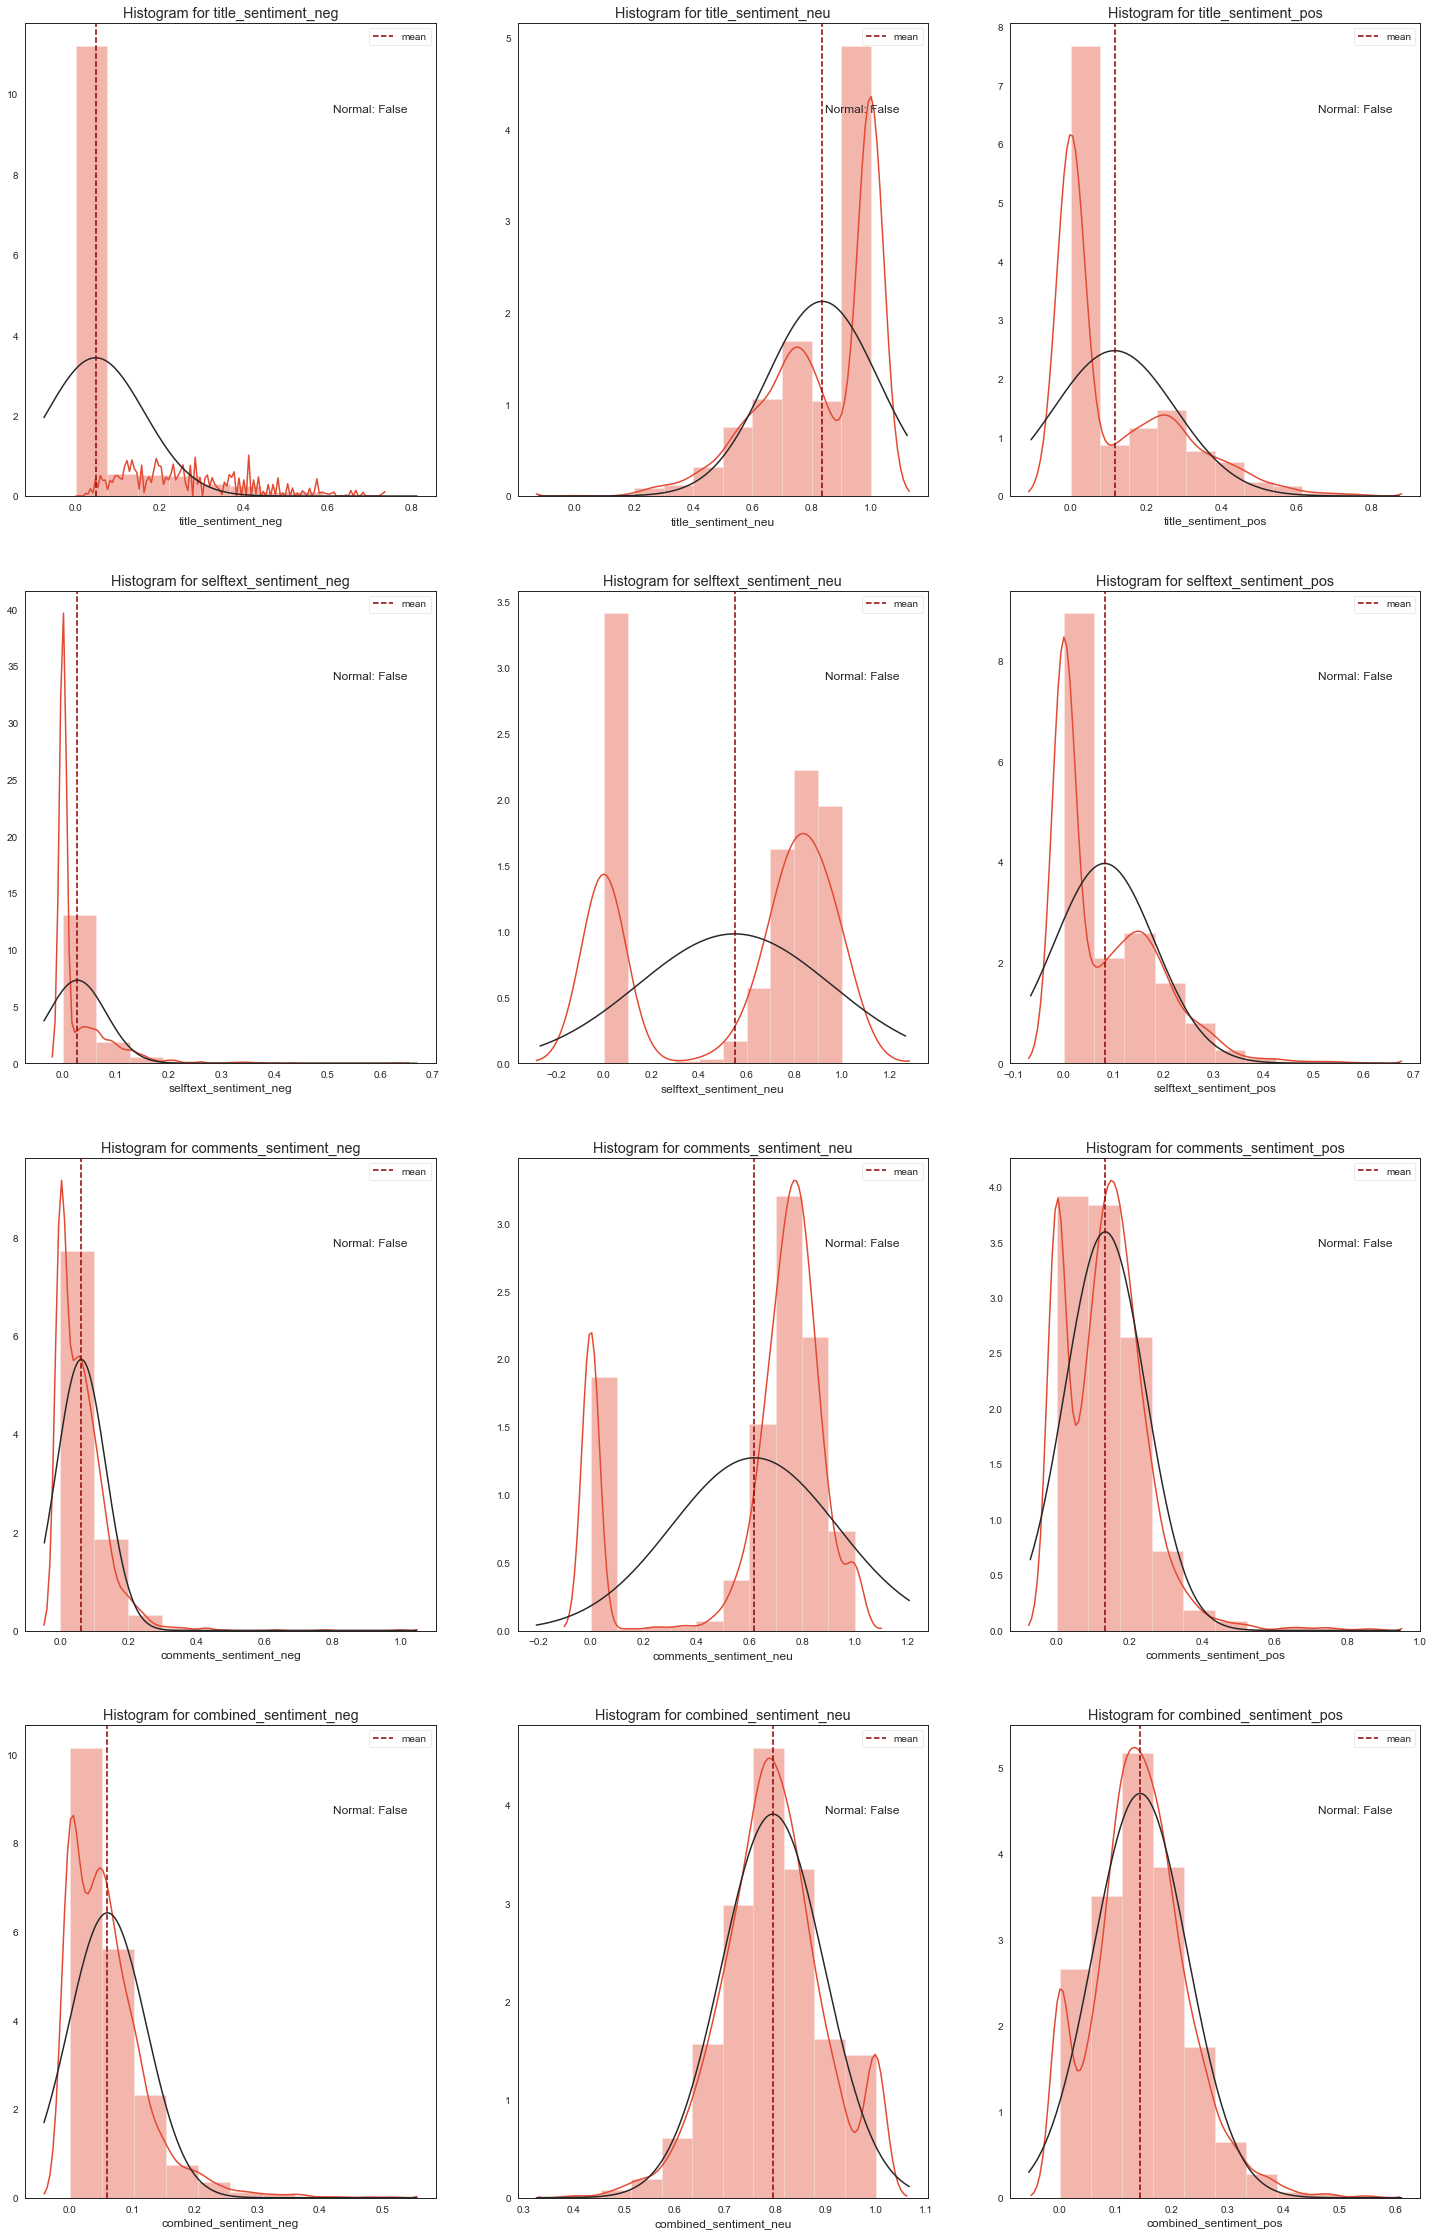

In [128]:
subplot_histograms(df_combined, list_of_columns, cols = 3)

### 3.2.2 FPL Only

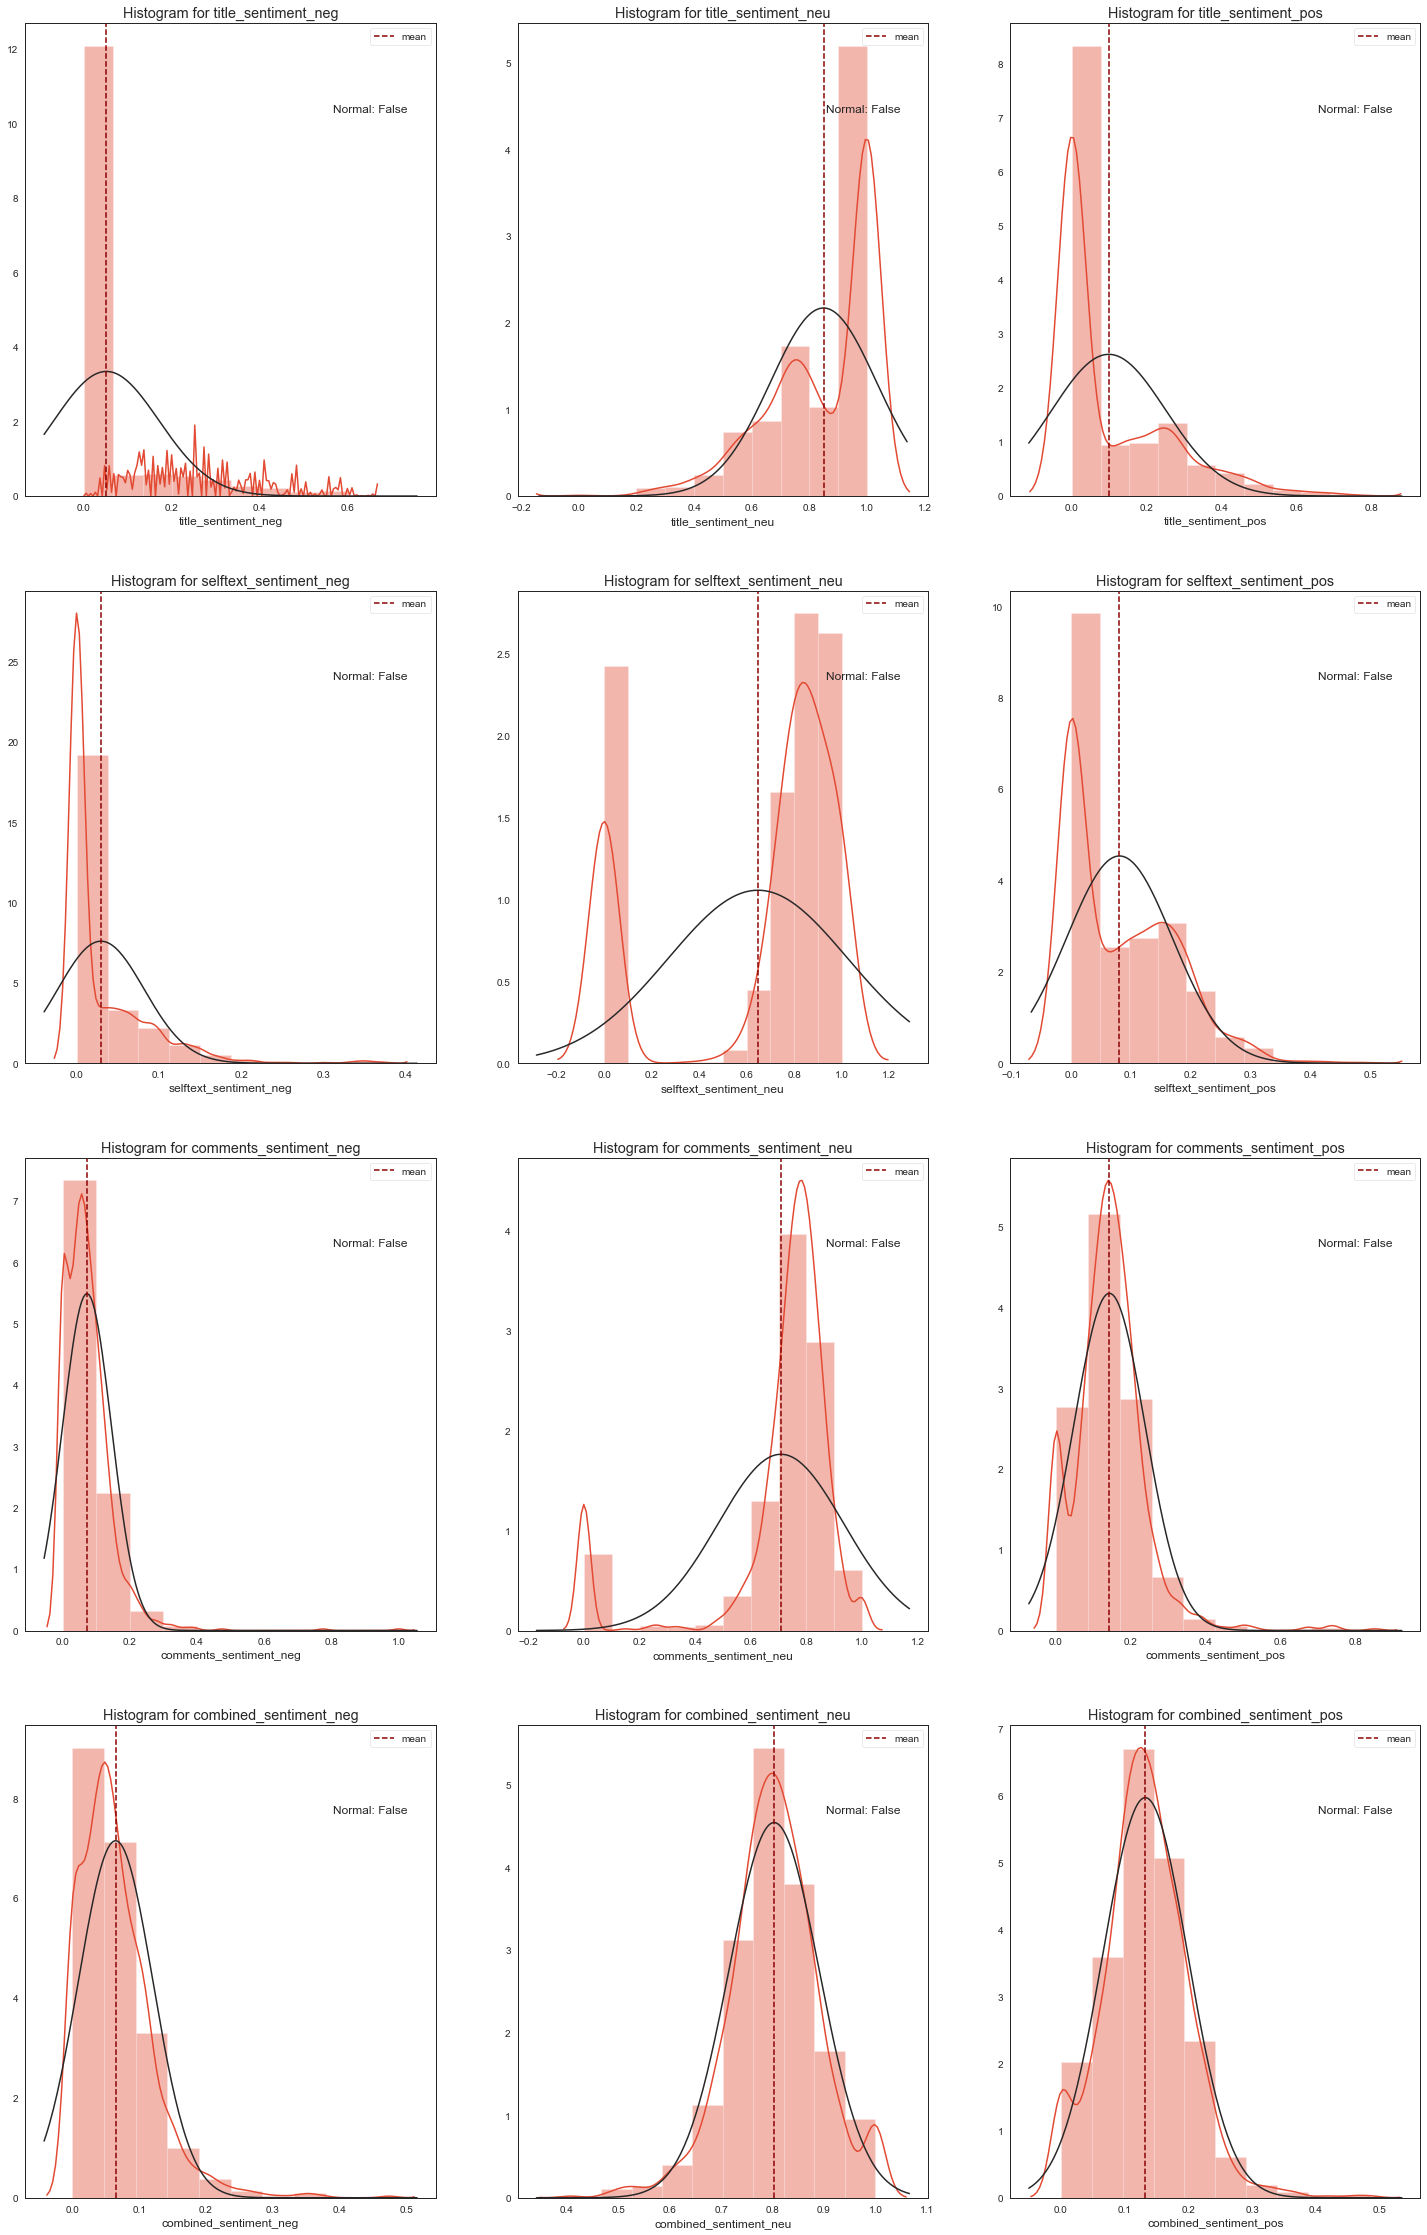

In [130]:
subplot_histograms(df_combined[df_combined['subreddit_name_prefixed']==0], list_of_columns)

### 3.2.3 EPL Only

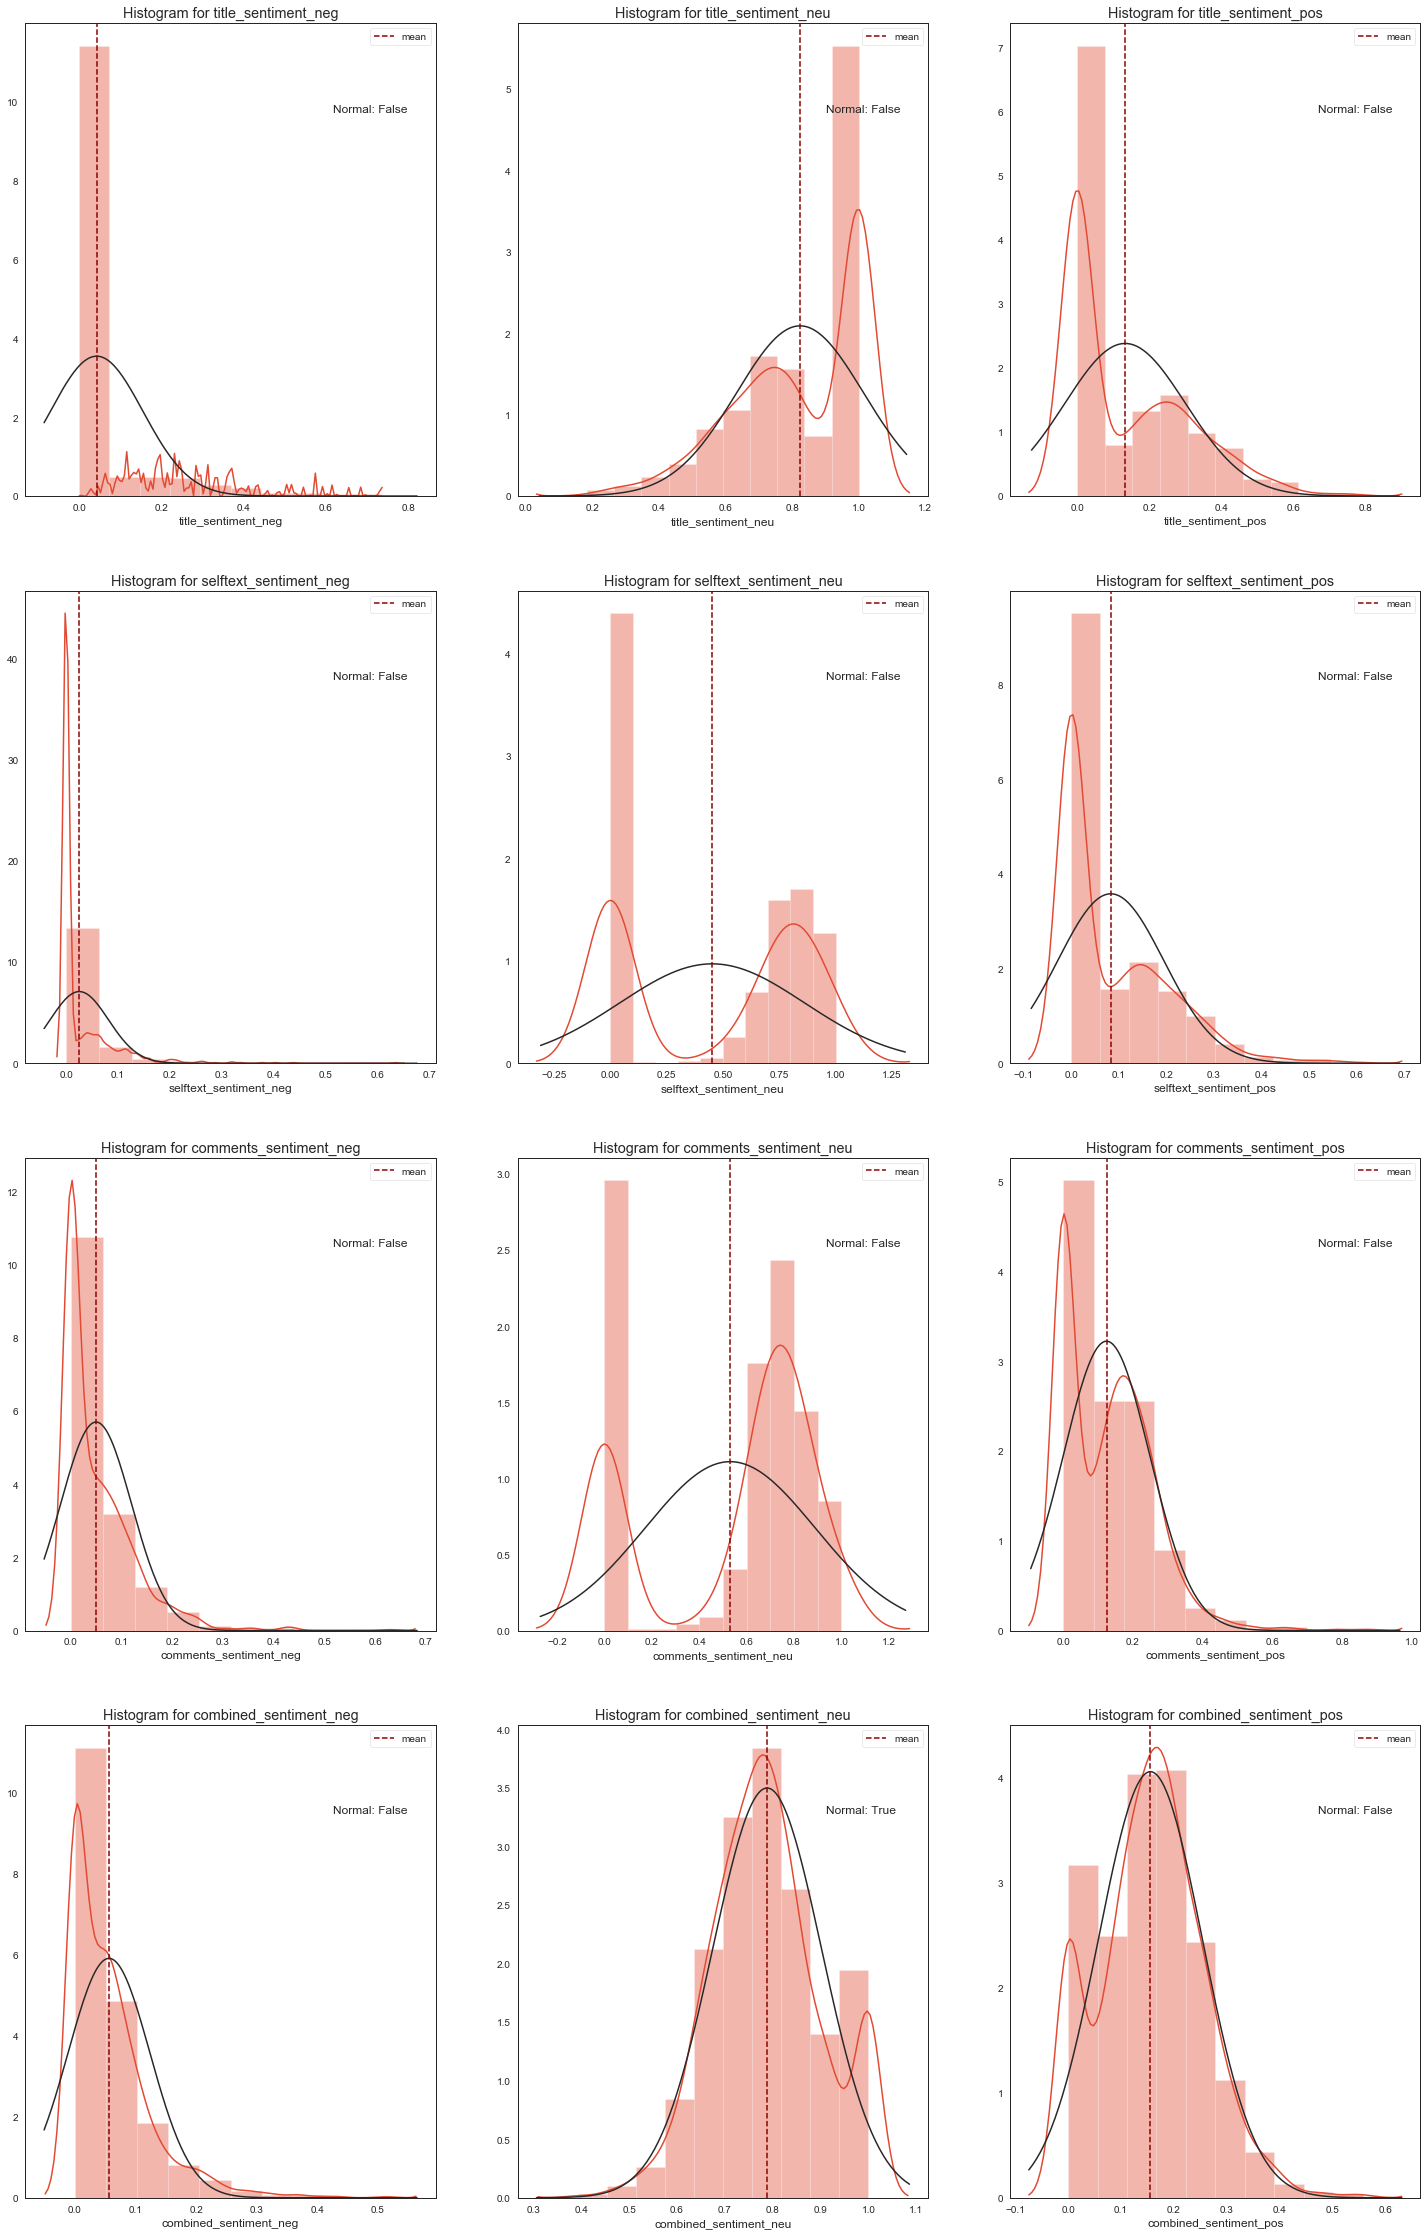

In [131]:
subplot_histograms(df_combined[df_combined['subreddit_name_prefixed']==1], list_of_columns)

#### Table: Mean Negative Sentiment by Reddit and Data Set

In [239]:
pd.DataFrame([[df_combined[df_combined['subreddit_name_prefixed']==0]['title_sentiment_neg'].mean(),
              df_combined[df_combined['subreddit_name_prefixed']==0]['selftext_sentiment_neg'].mean(),
              df_combined[df_combined['subreddit_name_prefixed']==0]['comments_sentiment_neg'].mean(),
              df_combined[df_combined['subreddit_name_prefixed']==0]['combined_sentiment_neg'].mean()],
             [df_combined[df_combined['subreddit_name_prefixed']==1]['title_sentiment_neg'].mean(),
              df_combined[df_combined['subreddit_name_prefixed']==1]['selftext_sentiment_neg'].mean(),
              df_combined[df_combined['subreddit_name_prefixed']==1]['comments_sentiment_neg'].mean(),
              df_combined[df_combined['subreddit_name_prefixed']==1]['combined_sentiment_neg'].mean()]],
             index = ['FPL', 'EPL'], columns = ['title', 'selftext', 'comments', 'combined'])


title  selftext  comments  combined
FPL  0.051398  0.029415  0.072712  0.064895
EPL  0.042939  0.025341  0.049669  0.056238

#### Table: Mean Positive Sentiment by Reddit and Data Set

In [240]:
pd.DataFrame([[df_combined[df_combined['subreddit_name_prefixed']==0]['title_sentiment_pos'].mean(),
              df_combined[df_combined['subreddit_name_prefixed']==0]['selftext_sentiment_pos'].mean(),
              df_combined[df_combined['subreddit_name_prefixed']==0]['comments_sentiment_pos'].mean(),
              df_combined[df_combined['subreddit_name_prefixed']==0]['combined_sentiment_pos'].mean()],
             [df_combined[df_combined['subreddit_name_prefixed']==1]['title_sentiment_pos'].mean(),
              df_combined[df_combined['subreddit_name_prefixed']==1]['selftext_sentiment_pos'].mean(),
              df_combined[df_combined['subreddit_name_prefixed']==1]['comments_sentiment_pos'].mean(),
              df_combined[df_combined['subreddit_name_prefixed']==1]['combined_sentiment_pos'].mean()]],
             index = ['FPL', 'EPL'], columns = ['title', 'selftext', 'comments', 'combined'])


title  selftext  comments  combined
FPL  0.098622  0.080756  0.142956  0.132161
EPL  0.133319  0.083341  0.124019  0.155406

<b>Analysis</b>

In general, both reddits have more positive sentiments than negative sentiments. It's also interesting to note that r/EPL is more positive on average, and r/FPL is slightly more negative than r/EPL.

This is just a superficial glance at overall sentiment - further hypothesis testing could be done to establish this relationship, but for now, this is out of the scope of this project.

## 4. Word Clouds  <a id='WordClouds'></a> 
<div align="right"><a href='#Table of Contents'>Back to Table of Contents</a></div>

In [186]:
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

We will run without stopwords to get a gauge of what needs to be cleaned/stopped when we run the fields through a vectorizer later.

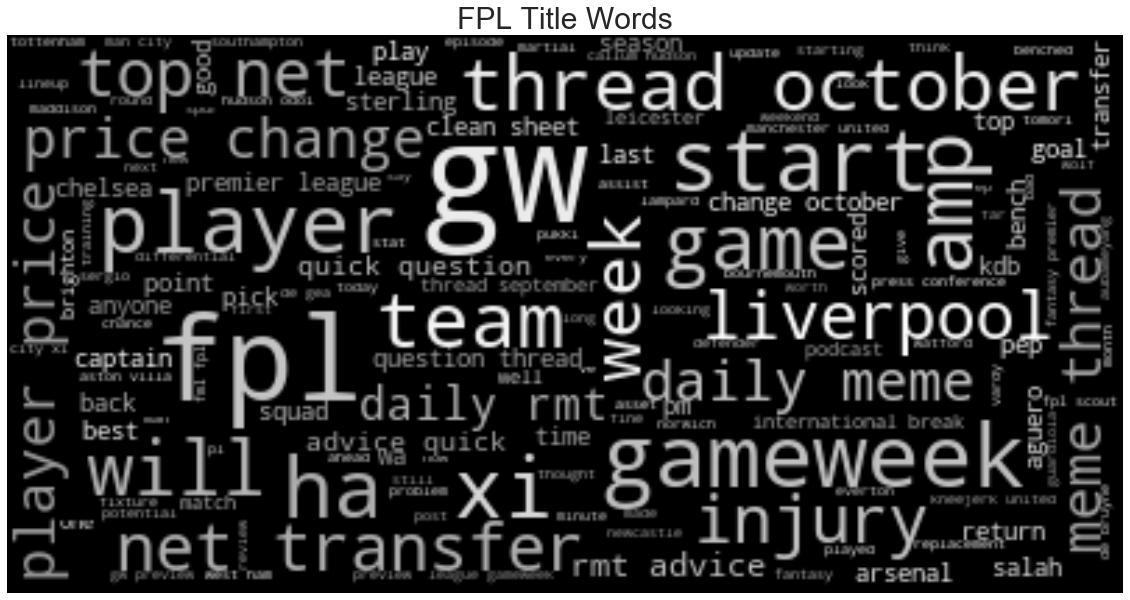

In [218]:
cloud = ''
for sentence in df_combined[df_combined['subreddit_name_prefixed']==0]['title'].tolist():
    cloud += sentence + ' '
    

plt.figure(figsize = (20, 20))
wc = WordCloud(max_font_size=50).generate(cloud)

default_colors = wc.to_array()
plt.title("FPL Title Words", fontsize = 30)
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3),
           interpolation="bilinear")

plt.axis("off")
plt.show()

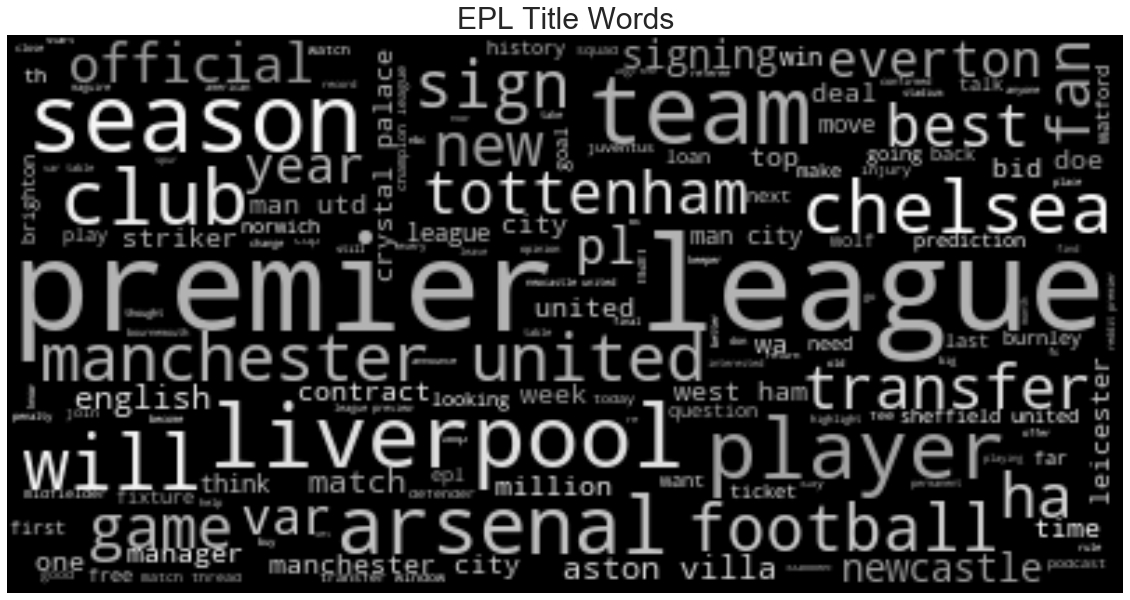

In [213]:
cloud = ''
for sentence in df_combined[df_combined['subreddit_name_prefixed']==1]['title'].tolist():
    cloud += sentence + ' '
    

plt.figure(figsize = (20, 20))
wc = WordCloud(max_font_size=50).generate(cloud)

default_colors = wc.to_array()
plt.title("EPL Title Words", fontsize = 30)
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3),
           interpolation="bilinear")


plt.axis("off")
plt.show()

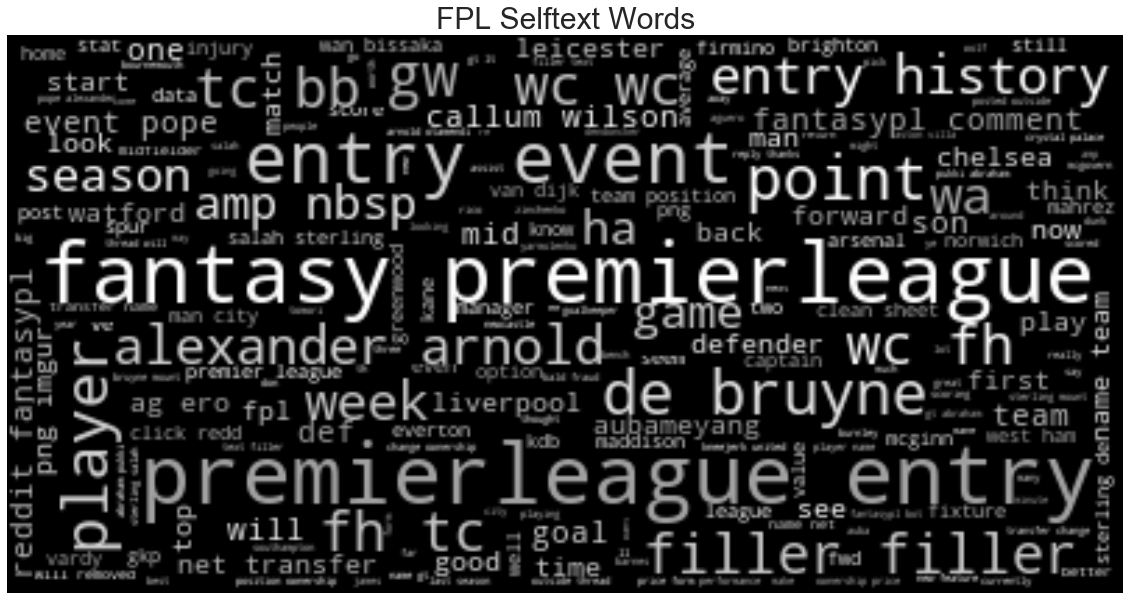

In [212]:
cloud = ''
for sentence in df_combined[df_combined['subreddit_name_prefixed']==0]['selftext'].tolist():
    cloud += sentence + ' '
    

plt.figure(figsize = (20, 20))
wc = WordCloud(max_font_size=50).generate(cloud)

default_colors = wc.to_array()
plt.title("FPL Selftext Words", fontsize = 30)
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3),
           interpolation="bilinear")
plt.axis("off")
plt.show()

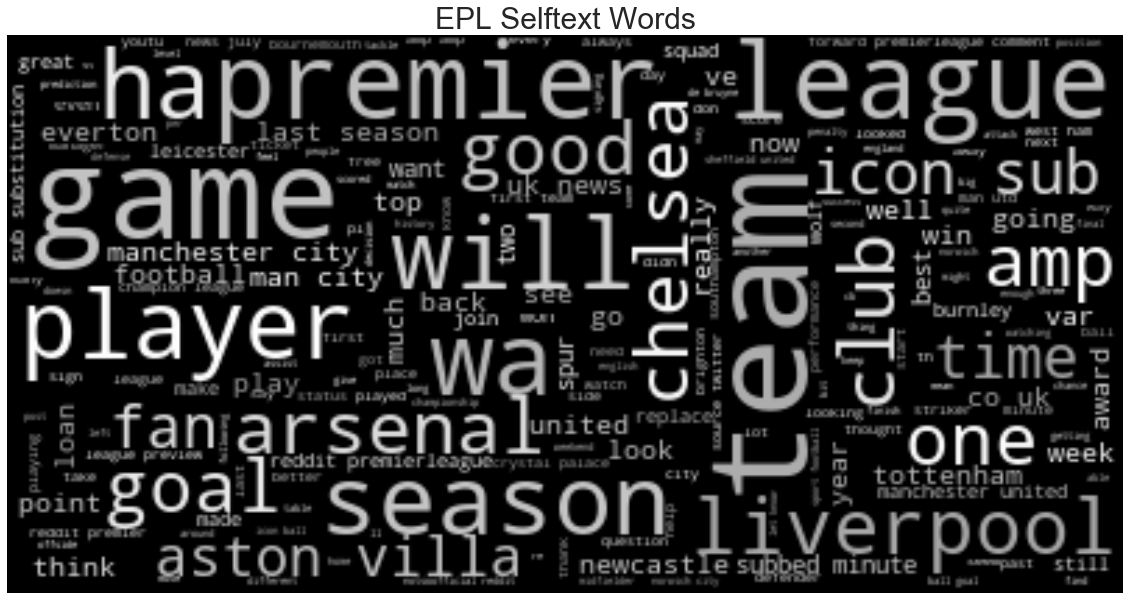

In [211]:
cloud = ''
for sentence in df_combined[df_combined['subreddit_name_prefixed']==1]['selftext'].tolist():
    cloud += sentence + ' '
    

plt.figure(figsize = (20, 20))
wc = WordCloud(max_font_size=50).generate(cloud)

default_colors = wc.to_array()
plt.title("EPL Selftext Words", fontsize = 30)
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3),
           interpolation="bilinear")
plt.axis("off")
plt.show()

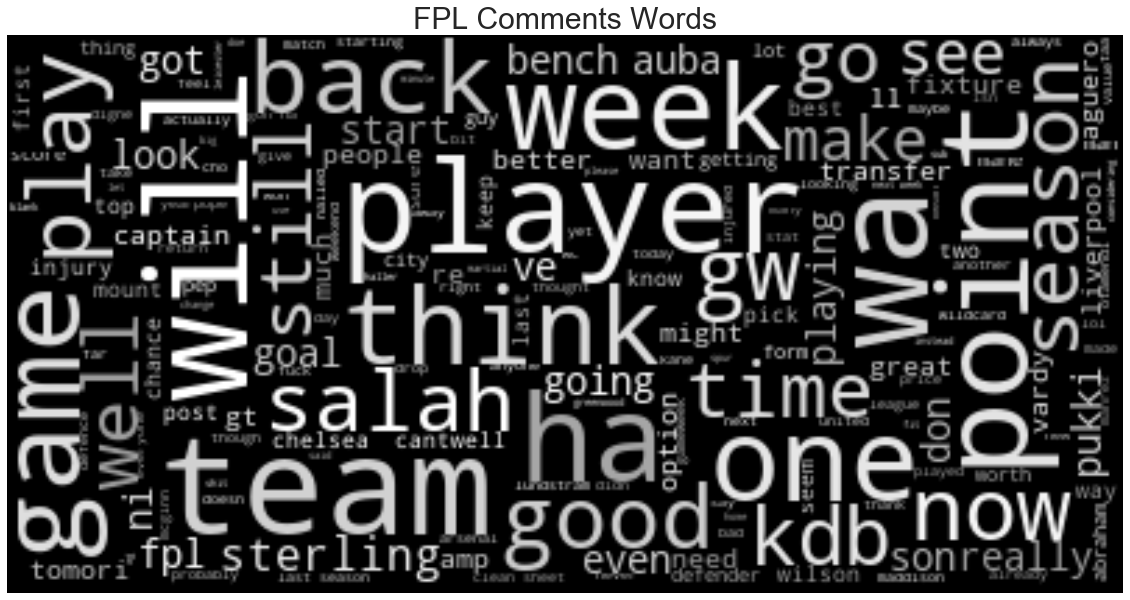

In [210]:
cloud = ''
for sentence in df_combined[df_combined['subreddit_name_prefixed']==0]['comments'].tolist():
    cloud += sentence + ' '
    

plt.figure(figsize = (20, 20))
wc = WordCloud(max_font_size=50).generate(cloud)

default_colors = wc.to_array()
plt.title("FPL Comments Words", fontsize = 30)
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3),
           interpolation="bilinear")
plt.axis("off")
plt.show()

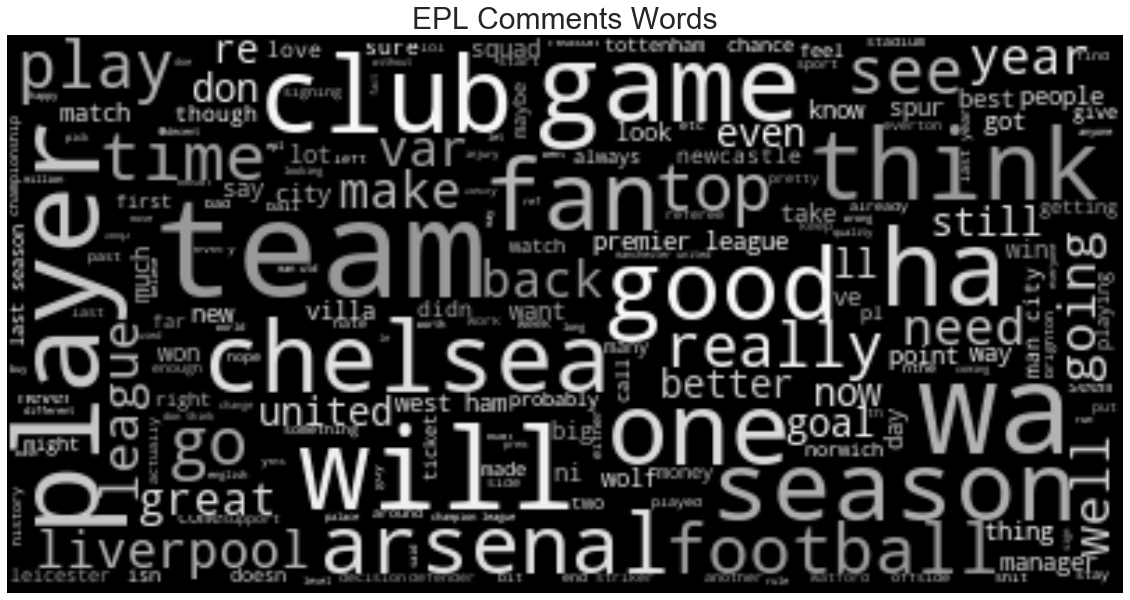

In [209]:
cloud = ''
for sentence in df_combined[df_combined['subreddit_name_prefixed']==1]['comments'].tolist():
    cloud += sentence + ' '
    

plt.figure(figsize = (20, 20))
wc = WordCloud(max_font_size=50).generate(cloud)

default_colors = wc.to_array()
plt.title("EPL Comments Words", fontsize = 30)
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3),
           interpolation="bilinear")
plt.axis("off")
plt.show()

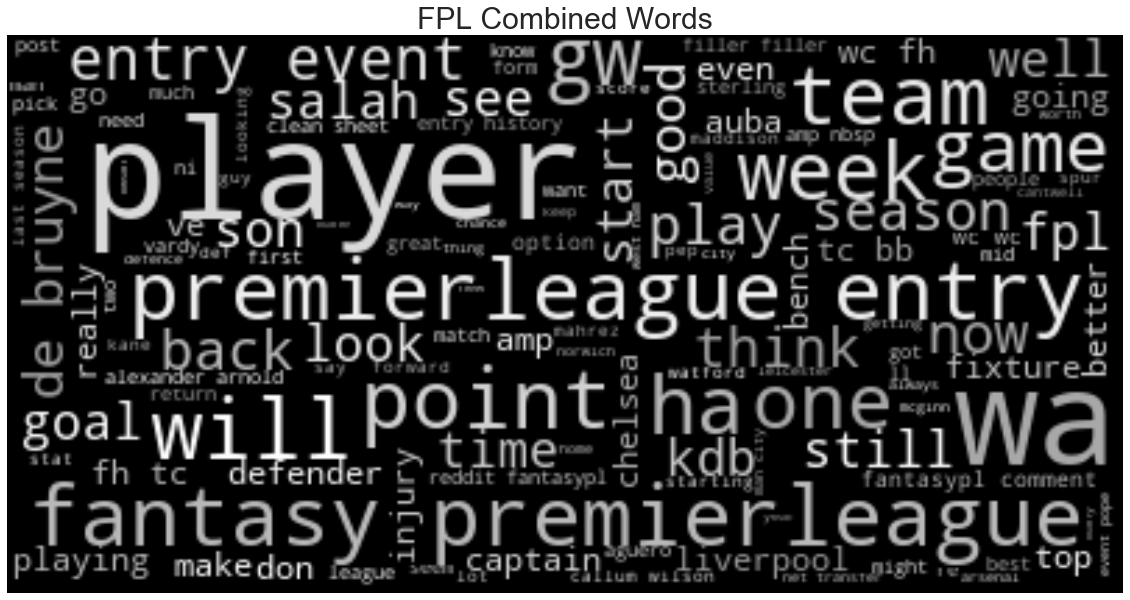

In [207]:
cloud = ''
for sentence in df_combined[df_combined['subreddit_name_prefixed']==0]['combined'].tolist():
    cloud += sentence + ' '
    

plt.figure(figsize = (20, 20))
wc = WordCloud(max_font_size=50).generate(cloud)

default_colors = wc.to_array()
plt.title("FPL Combined Words", fontsize = 30)
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3),
           interpolation="bilinear")
plt.axis("off")
plt.show()

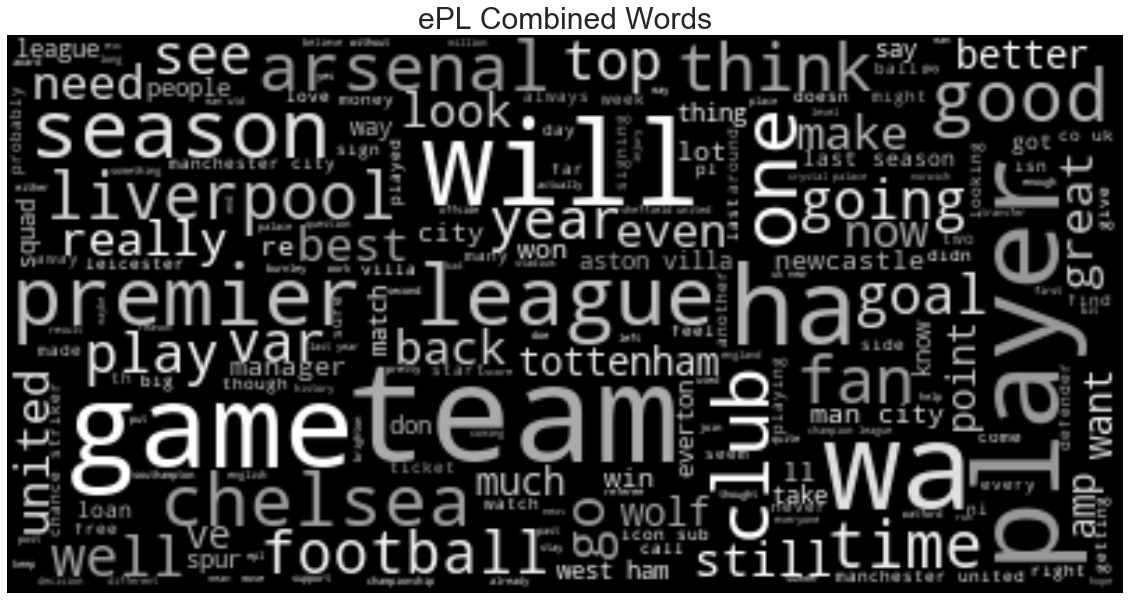

In [208]:
cloud = ''
for sentence in df_combined[df_combined['subreddit_name_prefixed']==1]['combined'].tolist():
    cloud += sentence + ' '
    

plt.figure(figsize = (20, 20))
wc = WordCloud(max_font_size=50).generate(cloud)

default_colors = wc.to_array()
plt.title("ePL Combined Words", fontsize = 30)
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3),
           interpolation="bilinear")
plt.axis("off")
plt.show()

<b> Analysis </b>

We have a rough sense of what words are used in each subreddit - 'fpl' and 'epl' will need to be added to our list of stop words during text vectorization.